# 📊 Exploratory Data Analysis (EDA) - Fruits-360 Veri Seti

Bu EDA’nın amacı, bir CNN sınıflandırıcı kurmadan önce Fruits-360 veri setini net bir şekilde anlamaktır.
İnceleyeceğimiz noktalar:

1. Veri setinin yapısı (klasörler, sınıflar)
2. Her bölümdeki görsel sayısı (eğitim/test)
3. Sınıf dağılımı ve olası dengesizlikler
4. Farklı sınıflardan örnek görseller
5. Görsellerin boyutu ve formatı


In [1]:
import os

base_dir = "/kaggle/input/fruits/fruits-360_100x100/fruits-360"
train_dir = os.path.join(base_dir, "Training")
test_dir = os.path.join(base_dir, "Test")

train_classes = sorted(os.listdir(train_dir))
test_classes = sorted(os.listdir(test_dir))

print(f"Number of classes (train): {len(train_classes)}")
print(f"Number of classes (test): {len(test_classes)}")
print("First 10 classes:", train_classes[:10])

Number of classes (train): 216
Number of classes (test): 216
First 10 classes: ['Apple 10', 'Apple 11', 'Apple 12', 'Apple 13', 'Apple 14', 'Apple 17', 'Apple 18', 'Apple 19', 'Apple 5', 'Apple 6']


In [2]:
train_counts = {cls: len(os.listdir(os.path.join(train_dir, cls))) for cls in train_classes}
test_counts = {cls: len(os.listdir(os.path.join(test_dir, cls))) for cls in test_classes}

print("Total training images:", sum(train_counts.values()))
print("Total test images:", sum(test_counts.values()))

Total training images: 110744
Total test images: 36947


### Veri Seti Genel Bakış
- Eğitim seti **216 sınıf** ve toplam **110.744 görsel** içeriyor.  
- Test seti de aynı şekilde **216 sınıf** ve **36.947 görsel** içeriyor.  
- Örnek sınıf etiketleri arasında birçok elma çeşidi yer almakta (*Apple 10, Apple 11, Apple 12* vb.), bu da veri setinin **ince ayrımlı sınıflandırma (fine-grained classification)** için uygun olduğunu gösteriyor.  

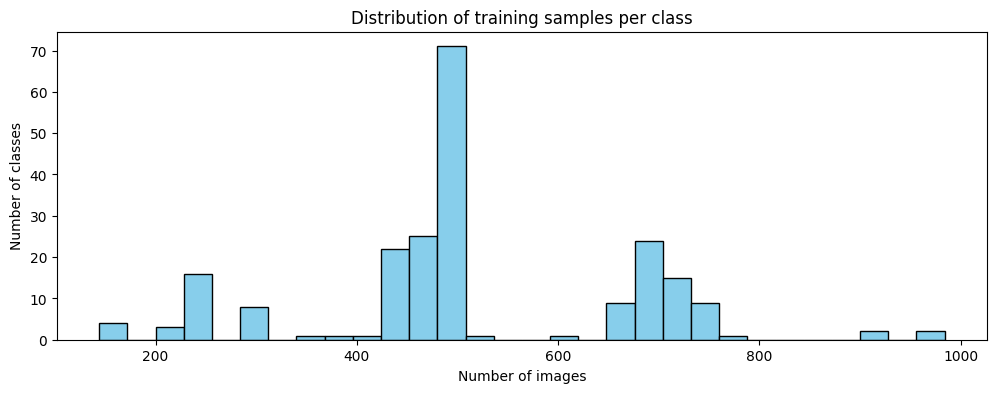

In [3]:
import matplotlib.pyplot as plt

train_sizes = list(train_counts.values())

plt.figure(figsize=(12,4))
plt.hist(train_sizes, bins=30, color="skyblue", edgecolor="black")
plt.title("Distribution of training samples per class")
plt.xlabel("Number of images")
plt.ylabel("Number of classes")
plt.show()

### Sınıf Dağılımı
- Eğitim örneklerinin histogramına bakıldığında, çoğu sınıfın **400–500 görsel** içerdiği görülüyor.  
- Bazı sınıflarda daha az ya da daha fazla görsel mevcut olsa da, veri seti genel olarak dengeli sayılabilir.   

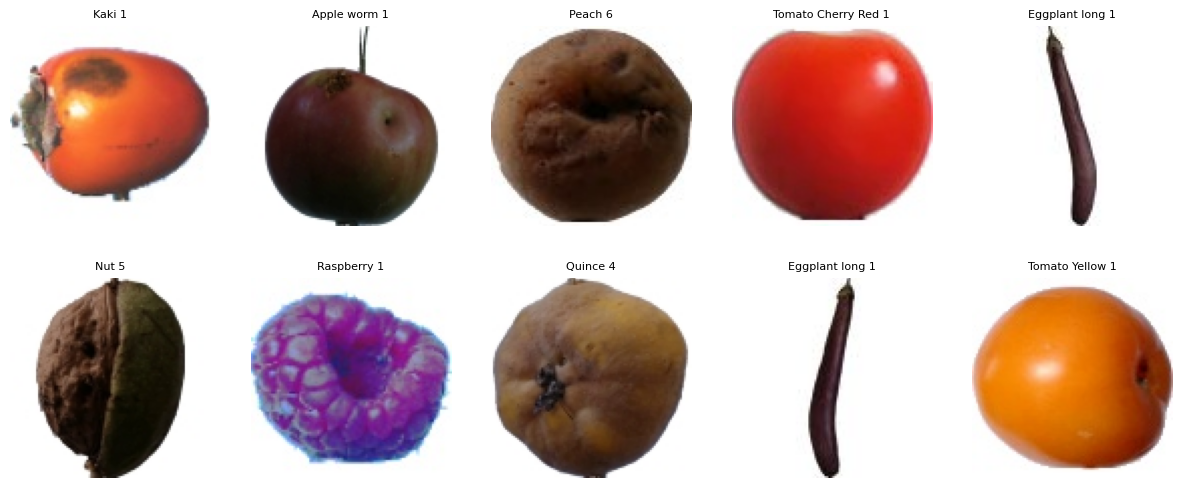

In [4]:
from PIL import Image
import random

fig, axes = plt.subplots(2, 5, figsize=(15,6))
for ax in axes.flat:
    cls = random.choice(train_classes)
    img_path = os.path.join(train_dir, cls, random.choice(os.listdir(os.path.join(train_dir, cls))))
    img = Image.open(img_path)
    ax.imshow(img)
    ax.set_title(cls, fontsize=8)
    ax.axis("off")
plt.show()

### Görsel İnceleme
- Rastgele seçilen örnekler, meyvelerin beyaz arka plan üzerinde düzgün şekilde kırpılmış olduğunu gösteriyor.  
- Sınıflar birbirinden görsel olarak ayırt edilebilir, ancak aynı meyvenin farklı türleri (ör. elma çeşitleri) arasında **ince görsel farklılıklar** bulunuyor.  

In [5]:
sample_class = train_classes[0]
sample_img_path = os.path.join(train_dir, sample_class, os.listdir(os.path.join(train_dir, sample_class))[0])
img = Image.open(sample_img_path)

print("Image size:", img.size)
print("Mode (channels):", img.mode)

Image size: (100, 100)
Mode (channels): RGB


### Görsellerin Özellikleri
- Tüm görseller **100 × 100 piksel** boyutunda ve **RGB kanallı**.  
- Tutarlı çözünürlük ve format, ön işleme adımlarını basitleştiriyor. Yeniden boyutlandırmaya gerek yok; ancak **normalizasyon ve veri artırma** önerilir.  
- PyTorch için giriş boyutu `(3, 100, 100)` olacak.

# 🛠️ Veri Önişleme (Preprocessing)

Bu aşamada ham veriyi modele uygun hale getireceğiz.  
İzlenecek adımlar:  
1. Görsellerin uygun formata dönüştürülmesi (tensor + normalize)  
2. Train, validation ve test setlerine ayrılması  
3. Veri artırma (**Data Augmentation**) yöntemleri ile modelin genelleme gücünü artırmak  
   - Rotation (döndürme)  
   - Flip (yansıtma)  
   - Random Zoom (yakınlaştırma/uzaklaştırma)  
   - Color Jitter (renk/parlaklık kontrast değişimi)  
4. Dataloaders ile PyTorch modeline hazır hale getirmek  
5. Görselleştirme ile augment edilmiş örnekleri incelemek  


In [6]:
import torch, torchvision
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

# Dataset paths
train_dir = os.path.join(base_dir, "Training")
test_dir = os.path.join(base_dir, "Test")

BATCH_SIZE = 32
IMG_SIZE = (100, 100)


# Transforms + Augmentation

In [7]:
# Data augmentation for training set
train_transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.RandomHorizontalFlip(p=0.5),     # Flip
    transforms.RandomRotation(20),              # Rotation
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)), # Zoom
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), # Color Jitter
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
])

# Validation & Test set: no augmentation
test_transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
])


# 📂 Train / Validation / Test

- **Train (Eğitim seti):** Model parametrelerini öğrenmek için kullanılır.  
- **Validation (Doğrulama seti):** Hiperparametre seçimi ve overfitting kontrolü için kullanılır.  
- **Test seti:** Eğitim bittiğinde modelin gerçek başarımını ölçmek için saklanır.  

**Fruits-360 datasetinde hali hazırda:**
- `Training` klasörü → eğitim verisi  
- `Test` klasörü → test verisi
bulunmakta.

**Random split ile validation seti oluşturuyoruz.**


In [8]:
# Load full training set
train_data_full = datasets.ImageFolder(root=train_dir, transform=train_transform)

# Train/Validation split (80/20)
train_size = int(0.8 * len(train_data_full))
val_size = len(train_data_full) - train_size
train_data, val_data = random_split(train_data_full, [train_size, val_size])

# Apply test_transform to validation set manually
val_data.dataset.transform = test_transform

# Test dataset
test_data = datasets.ImageFolder(root=test_dir, transform=test_transform)

# Dataloaders
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"Train samples: {len(train_data)}, Validation samples: {len(val_data)}, Test samples: {len(test_data)}")


Train samples: 88595, Validation samples: 22149, Test samples: 36947


**🔍 Doğrulama Seti Neden Gerekli?**

- Validation setini kullanmazsan **overfitting** olup olmadığını anlayamayız.
- Validation **accuracy/loss grafikleri**, eğitim sırasında modelin **ne zaman durması gerektiğini** gösterir (*early stopping*).  
- Hiperparametreler (learning rate, batch size, optimizer, augmentation) validation setine göre seçilir.  


# Augmentation Sonrası Görselleştirme

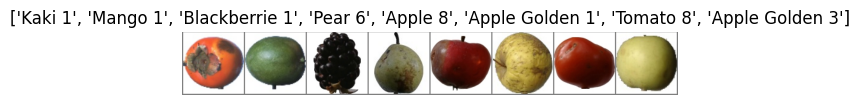

In [10]:
# Helper function to show images
def imshow(img, title=None):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title is not None:
        plt.title(title)
    plt.axis("off")
    plt.show()

# Show a batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:8], nrow=8),
       title=[train_data.dataset.classes[labels[j]] for j in range(8)])


### 🔑 Özet
- Görseller uygun boyuta getirildi ve tensöre dönüştürüldü.  
- Eğitim seti için **augmentation** uygulandı (rotation, flip, zoom, color jitter).  
- Validation ve Test setleri temiz, yalnızca normalize edildi.  
- DataLoader’lar hazır hale getirildi.  
- Augmentation sonrasında bazı örnekler görselleştirilerek kontrol edildi.  

# Model Seçimi - ResNet9

Bu aşamada CNN tabanlı **ResNet9** mimarisini uygulamaya karar verdim.  
Seçim nedenim:  
- Fruits-360 gibi küçük boyutlu (100×100) görseller için **hafif ama güçlü** bir model olması. 
- **Residual bağlantılar (skip connections)** sayesinde derin ağlarda görülen *vanishing gradient* sorununu azaltır.  
- **Batch Normalization** ve **Dropout** ile daha kararlı ve genellenebilir öğrenme sağlar.  
- Parametre sayısı ResNet18’e göre daha azdır, bu yüzden eğitim süresi daha kısadır.  

Model bileşenleri:  
- **Convolutional Layers** → Görsel özelliklerin çıkarılması  
- **Pooling Layers** → Boyut küçültme ve öznitelik yoğunlaştırma  
- **Residual Blocks** → Gradient akışını koruma ve performansı artırma  
- **Dropout** → Overfitting riskini azaltma  
- **Fully Connected Layer** → Sınıflandırma (216 sınıf için Softmax çıkış)  


In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResNet9(nn.Module):
    def __init__(self, in_channels=3, num_classes=216):
        super().__init__()

        # İlk convolution blokları
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)   # 100x100 -> 50x50
        )

        # Residual blok 1
        self.res1 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128)
        )

        # Orta convolution blokları
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)   # 50x50 -> 25x25
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)   # 25x25 -> 12x12
        )

        # Residual blok 2
        self.res2 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512)
        )

        # Classifier (Dropout dahil)
        self.classifier = nn.Sequential(
            nn.MaxPool2d(4),      # 12x12 -> 3x3
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(512*3*3, num_classes)
        )

    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)

        # Residual connection 1
        r1 = self.res1(out)
        out = F.relu(out + r1)

        out = self.conv3(out)
        out = self.conv4(out)

        # Residual connection 2
        r2 = self.res2(out)
        out = F.relu(out + r2)

        out = self.classifier(out)
        return out


In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet9(in_channels=3, num_classes=216).to(device)
print("Device:", device)
print(model)


Device: cuda
ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3)

# 🎯 Modelin Eğitimi

Bu aşamada ResNet9 modelimizi **train/validation** setleri üzerinde eğiteceğiz.  
Adımlar:  
1. Kayıp fonksiyonu (Loss) ve optimizasyon algoritmasını tanımlama  
2. Eğitim (training) ve doğrulama (validation) döngülerini oluşturma  
3. Epoch’lar boyunca loss ve accuracy değerlerini kaydetme  
4. Eğitim sonrası sonuçları görselleştirme  


**Loss ve Optimizer**

In [14]:
import torch.optim as optim

# Kayıp fonksiyonu: çok sınıflı sınıflandırma için CrossEntropyLoss
criterion = nn.CrossEntropyLoss()

# Optimizasyon: Adam
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Opsiyonel: learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


**Eğitim ve Doğrulama Fonksiyonları**

In [15]:
def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc


def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc


**Eğitim Döngüsü**

In [16]:
from tqdm.notebook import tqdm
import torch

num_epochs = 10

train_losses, val_losses = [], []
train_accs, val_accs = [], []

best_val_acc = 0.0
best_model_path = "best_resnet9.pth"

for epoch in range(num_epochs):
    # -----------------
    # Training
    # -----------------
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=True)
    
    for images, labels in train_bar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        train_bar.set_postfix(loss=loss.item())

    train_loss = running_loss / total
    train_acc = 100. * correct / total

    # -----------------
    # Validation
    # -----------------
    val_loss, val_acc = validate(model, val_loader, criterion, device)

    # -----------------
    # Record metrics
    # -----------------
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    # Scheduler step
    scheduler.step()

    # -----------------
    # Save best model
    # -----------------
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), best_model_path)
        print(f"✅ Best model saved at epoch {epoch+1} with val_acc={val_acc:.2f}%")

    # -----------------
    # Epoch summary
    # -----------------
    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%", flush=True)

print(f"Training complete. Best validation accuracy: {best_val_acc:.2f}%")


Epoch 1/10 [Train]:   0%|          | 0/2769 [00:00<?, ?it/s]

✅ Best model saved at epoch 1 with val_acc=99.22%
Epoch [1/10] Train Loss: 0.5532 | Train Acc: 85.95% Val Loss: 0.0288 | Val Acc: 99.22%


Epoch 2/10 [Train]:   0%|          | 0/2769 [00:00<?, ?it/s]

✅ Best model saved at epoch 2 with val_acc=99.59%
Epoch [2/10] Train Loss: 0.0776 | Train Acc: 97.71% Val Loss: 0.0141 | Val Acc: 99.59%


Epoch 3/10 [Train]:   0%|          | 0/2769 [00:00<?, ?it/s]

Epoch [3/10] Train Loss: 0.0513 | Train Acc: 98.44% Val Loss: 0.0164 | Val Acc: 99.38%


Epoch 4/10 [Train]:   0%|          | 0/2769 [00:00<?, ?it/s]

Epoch [4/10] Train Loss: 0.0362 | Train Acc: 98.94% Val Loss: 0.0197 | Val Acc: 99.49%


Epoch 5/10 [Train]:   0%|          | 0/2769 [00:00<?, ?it/s]

Epoch [5/10] Train Loss: 0.0291 | Train Acc: 99.16% Val Loss: 0.0402 | Val Acc: 98.94%


Epoch 6/10 [Train]:   0%|          | 0/2769 [00:00<?, ?it/s]

Epoch [6/10] Train Loss: 0.0198 | Train Acc: 99.41% Val Loss: 0.0368 | Val Acc: 99.31%


Epoch 7/10 [Train]:   0%|          | 0/2769 [00:00<?, ?it/s]

✅ Best model saved at epoch 7 with val_acc=99.99%
Epoch [7/10] Train Loss: 0.0207 | Train Acc: 99.41% Val Loss: 0.0007 | Val Acc: 99.99%


Epoch 8/10 [Train]:   0%|          | 0/2769 [00:00<?, ?it/s]

✅ Best model saved at epoch 8 with val_acc=100.00%
Epoch [8/10] Train Loss: 0.0021 | Train Acc: 99.93% Val Loss: 0.0000 | Val Acc: 100.00%


Epoch 9/10 [Train]:   0%|          | 0/2769 [00:00<?, ?it/s]

✅ Best model saved at epoch 9 with val_acc=100.00%
Epoch [9/10] Train Loss: 0.0009 | Train Acc: 99.97% Val Loss: 0.0000 | Val Acc: 100.00%


Epoch 10/10 [Train]:   0%|          | 0/2769 [00:00<?, ?it/s]

Epoch [10/10] Train Loss: 0.0007 | Train Acc: 99.98% Val Loss: 0.0001 | Val Acc: 100.00%
Training complete. Best validation accuracy: 100.00%


**Eğitim Sonuçlarını Görselleştirme**

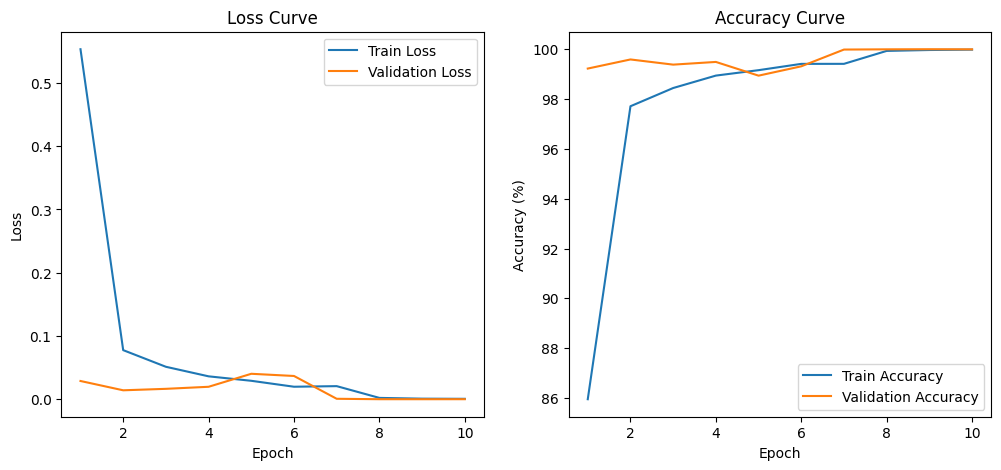

In [17]:
import matplotlib.pyplot as plt

epochs_range = range(1, num_epochs+1)

plt.figure(figsize=(12,5))

# Loss grafiği
plt.subplot(1,2,1)
plt.plot(epochs_range, train_losses, label="Train Loss")
plt.plot(epochs_range, val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()

# Accuracy grafiği
plt.subplot(1,2,2)
plt.plot(epochs_range, train_accs, label="Train Accuracy")
plt.plot(epochs_range, val_accs, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy Curve")
plt.legend()

plt.show()


### 🔑 Notlar
- **CrossEntropyLoss** çok sınıflı problemler için standart seçimdir.  
- **Adam optimizer** başlangıç için uygundur, fakat farklı optimizasyonlar (SGD+momentum) da denenebilir.  
- **Validation accuracy** modelin genelleme başarısını izlememize yardımcı olur.  
- **Grafikler**, overfitting olup olmadığını görmemizi sağlar:  
  - Eğer train accuracy yükselirken validation accuracy sabit/düşüyorsa → overfitting var.  
  - Eğer her ikisi de artıyorsa → model iyi öğreniyor.  


# 🧪 Modelin Test Edilmesi

Eğitim sırasında en iyi validation accuracy’ye sahip model kaydedilmişti (`best_resnet9.pth`).  
Şimdi bu modeli yükleyip test seti üzerinde değerlendireceğiz.  


**Kaydedilen modeli yükleme**

In [18]:
# Best modeli yükle
model = ResNet9(in_channels=3, num_classes=216).to(device)

if os.path.exists(best_model_path):
    model.load_state_dict(torch.load(best_model_path, map_location=device))
    model.eval()
    print("✅ Best saved model loaded.")
else:
    print("⚠️ No saved model found, please train first.")

✅ Best saved model loaded.


**Test seti üzerinden değerlendirme**

In [19]:
test_loss, test_acc = validate(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.2f}%")


Test Loss: 0.0213
Test Accuracy: 99.67%


# 📊 4. Modelin Değerlendirilmesi

Eğitim sonrası modelimizi farklı açılardan değerlendireceğiz:

1. **Accuracy ve Loss Grafikleri (epoch bazında)** → Eğitim sürecinin nasıl ilerlediğini görmek için  
2. **Confusion Matrix & Classification Report** → Hangi sınıflarda modelin daha başarılı veya zorlandığını görmek için  
3. **Grad-CAM Heatmap** → Test görüntülerinde modelin hangi bölgelerden etkilendiğini görselleştirmek için

**Confusion Matrix & Classification Report**

                           precision    recall  f1-score   support

                 Apple 10       1.00      1.00      1.00       231
                 Apple 11       1.00      1.00      1.00       142
                 Apple 12       1.00      1.00      1.00       154
                 Apple 13       1.00      1.00      1.00       235
                 Apple 14       1.00      1.00      1.00       154
                 Apple 17       1.00      1.00      1.00       201
                 Apple 18       1.00      1.00      1.00       160
                 Apple 19       1.00      1.00      1.00       241
                  Apple 5       1.00      1.00      1.00       146
                  Apple 6       1.00      1.00      1.00       157
                  Apple 7       1.00      1.00      1.00       229
                  Apple 8       1.00      1.00      1.00       228
                  Apple 9       1.00      1.00      1.00       231
         Apple Braeburn 1       0.98      0.93      0.95     

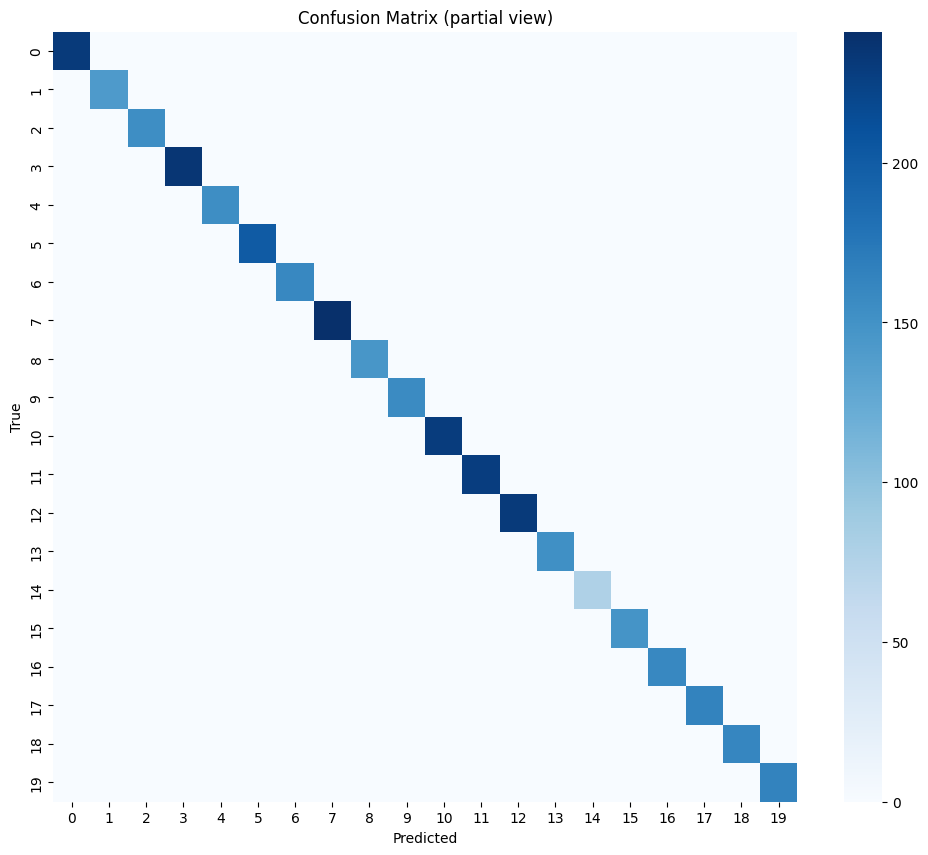

In [21]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

all_preds, all_labels = [], []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Classification report
print(classification_report(all_labels, all_preds, target_names=test_data.classes))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(12,10))
sns.heatmap(cm[:20, :20], cmap="Blues", annot=False)  # ilk 20 sınıfı gösterelim
plt.title("Confusion Matrix (partial view)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


## 🔥 Grad-CAM ile Çoklu Görsel Görselleştirme

Bu bölümde test setinden birkaç örnek alıp, modelin karar verirken hangi bölgeleri kullandığını görselleştireceğiz.  
Her görsel için:  
- **Orijinal Görsel**  
- **Grad-CAM Heatmap**  
- **Heatmap bindirilmiş hali (superimposed)**  

In [29]:
from torchvision import models
import cv2

# Grad-CAM helper
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0]

        def forward_hook(module, input, output):
            self.activations = output

        target_layer.register_forward_hook(forward_hook)
        target_layer.register_backward_hook(backward_hook)

    def generate(self, input_image, class_idx):
        self.model.zero_grad()
        output = self.model(input_image)
        target = output[0, class_idx]
        target.backward()

        gradients = self.gradients[0].cpu().data.numpy()
        activations = self.activations[0].cpu().data.numpy()

        weights = gradients.mean(axis=(1,2))
        cam = np.zeros(activations.shape[1:], dtype=np.float32)

        for i, w in enumerate(weights):
            cam += w * activations[i, :, :]

        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, (100,100))  # input image size
        cam = cam - np.min(cam)
        cam = cam / np.max(cam)
        return cam

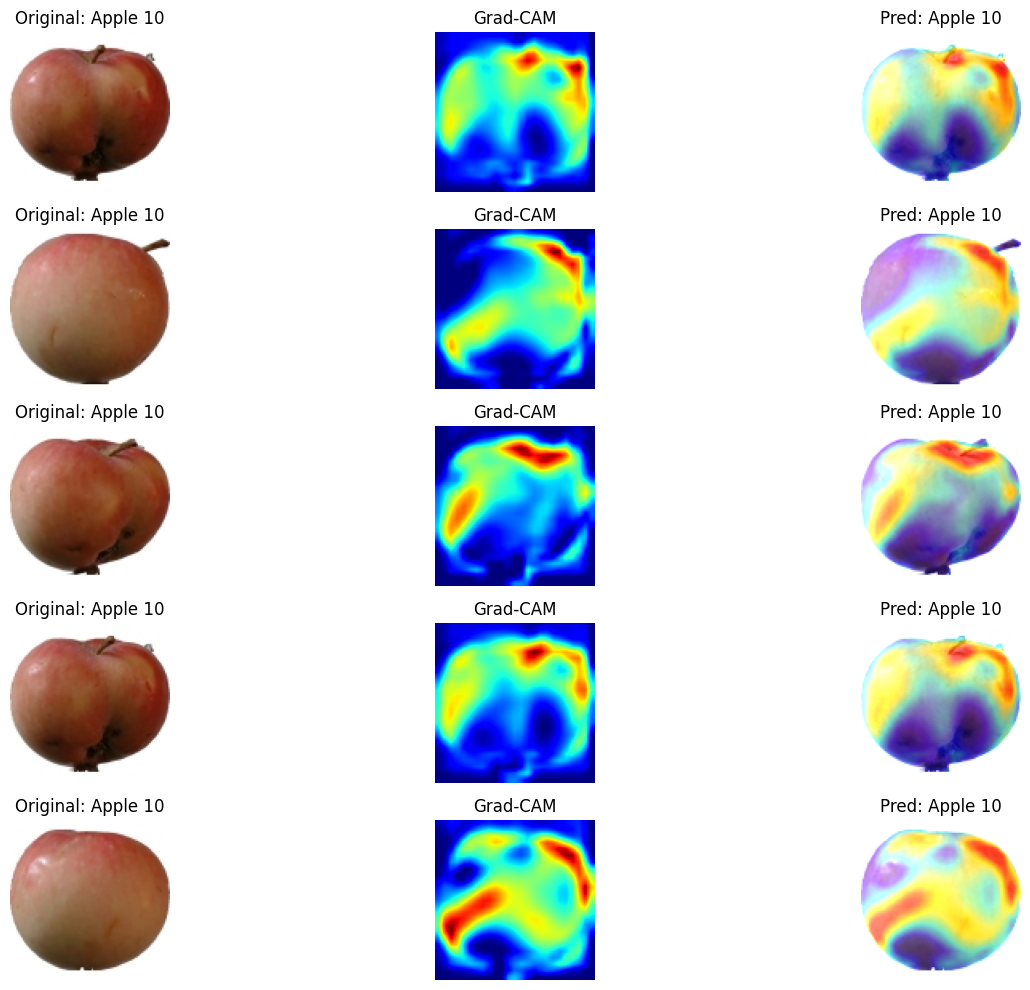

In [30]:
import random

# Testten birkaç örnek seçelim
dataiter = iter(test_loader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)

gradcam = GradCAM(model, model.conv4[0])  # son conv layer

# Rastgele 5 örnek seçelim
indices = random.sample(range(len(images)), 5)

plt.figure(figsize=(15,10))

for i, idx in enumerate(indices):
    img = images[idx].unsqueeze(0)
    label = labels[idx].item()
    
    output = model(img)
    pred_class = output.argmax(dim=1).item()
    
    cam = gradcam.generate(img, pred_class)
    
    # Normalize image back
    img_disp = images[idx].cpu().permute(1,2,0).numpy()
    img_disp = (img_disp*0.5 + 0.5).clip(0,1)
    
    heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    superimposed = (0.6*heatmap/255 + img_disp).clip(0,1)
    
    # Plot
    plt.subplot(len(indices), 3, i*3+1)
    plt.imshow(img_disp)
    plt.title(f"Original: {test_data.classes[label]}")
    plt.axis("off")
    
    plt.subplot(len(indices), 3, i*3+2)
    plt.imshow(cam, cmap="jet")
    plt.title("Grad-CAM")
    plt.axis("off")
    
    plt.subplot(len(indices), 3, i*3+3)
    plt.imshow(superimposed)
    plt.title(f"Pred: {test_data.classes[pred_class]}")
    plt.axis("off")

plt.tight_layout()
plt.show()

# 🔧 5. Hiperparametre Optimizasyonu

Modelimiz yüksek doğruluk elde etse de ödev gereği bazı hiperparametreler üzerinde denemeler yapacağız.  
Değiştirilebilecek parametreler:  
- Katman sayısı (ekstra convolution/dense layer ekleme)  
- Filtre sayısı (örn. 64 yerine 32/128 kullanmak)  
- Kernel boyutları (3x3 yerine 5x5 denemek)  
- Dropout oranı (0.3, 0.5, 0.7 gibi)  
- Dense layer boyutları (örn. 512 yerine 256)  
- Learning rate (örn. 1e-2, 1e-3, 1e-4)  
- Batch size (32, 64, 128)  
- Optimizer seçimi (Adam, SGD, RMSProp)  

Ayrıca, **Grid Search, Random Search, Bayesian Optimization** gibi otomatik yöntemler de kullanılabilir.

**1️⃣ Learning Rate Denemeleri**

In [35]:
lrs = [1e-2, 1e-3, 1e-4]
histories = {}

for lr in lrs:
    print(f"\n🔎 Learning rate test: {lr}")
    model = ResNet9(in_channels=3, num_classes=216).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    train_accs, val_accs = [], []
    train_losses, val_losses = [], []

    for epoch in range(5):
        tl, ta = train_one_epoch(model, train_loader, optimizer, criterion, device)
        vl, va = validate(model, val_loader, criterion, device)

        train_losses.append(tl)
        val_losses.append(vl)
        train_accs.append(ta)
        val_accs.append(va)

        print(f"Epoch {epoch+1}: Train Acc={ta:.2f}%, Val Acc={va:.2f}% | Train Loss={tl:.4f}, Val Loss={vl:.4f}")

    histories[lr] = (train_losses, val_losses, train_accs, val_accs)


🔎 Learning rate test: 0.01
Epoch 1: Train Acc=61.23%, Val Acc=94.57% | Train Loss=2.1025, Val Loss=0.1697
Epoch 2: Train Acc=87.15%, Val Acc=97.84% | Train Loss=0.4072, Val Loss=0.0645
Epoch 3: Train Acc=91.05%, Val Acc=98.35% | Train Loss=0.2840, Val Loss=0.0464
Epoch 4: Train Acc=93.17%, Val Acc=99.38% | Train Loss=0.2233, Val Loss=0.0216
Epoch 5: Train Acc=94.47%, Val Acc=99.09% | Train Loss=0.1853, Val Loss=0.0262

🔎 Learning rate test: 0.001
Epoch 1: Train Acc=78.32%, Val Acc=96.25% | Train Loss=1.0237, Val Loss=0.1288
Epoch 2: Train Acc=95.33%, Val Acc=96.93% | Train Loss=0.1811, Val Loss=0.1921
Epoch 3: Train Acc=97.36%, Val Acc=98.67% | Train Loss=0.0986, Val Loss=0.0415
Epoch 4: Train Acc=98.32%, Val Acc=95.56% | Train Loss=0.0588, Val Loss=0.2546
Epoch 5: Train Acc=98.65%, Val Acc=98.87% | Train Loss=0.0475, Val Loss=0.0856

🔎 Learning rate test: 0.0001
Epoch 1: Train Acc=85.55%, Val Acc=98.04% | Train Loss=0.5659, Val Loss=0.0691
Epoch 2: Train Acc=97.59%, Val Acc=99.30% | 

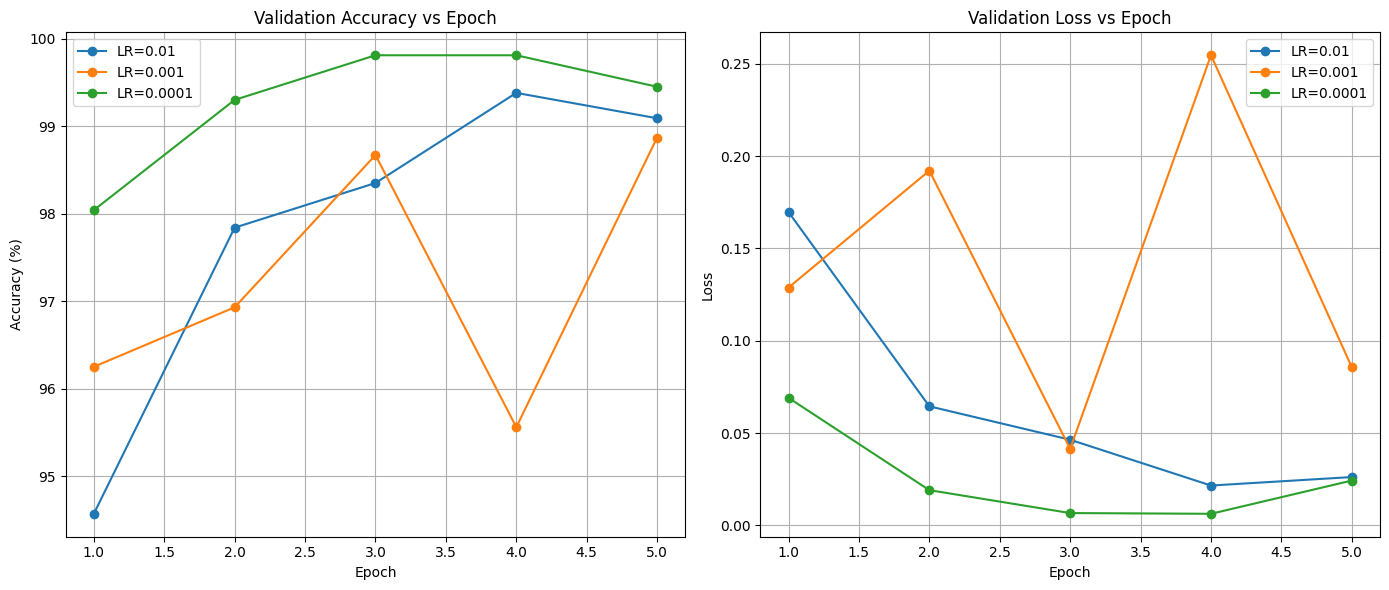

In [40]:
import matplotlib.pyplot as plt

epochs = range(1, 6)
plt.figure(figsize=(14,6))

# Validation accuracy
plt.subplot(1,2,1)
for lr, data in histories.items():
    plt.plot(epochs, data["val_acc"], marker="o", label=f"LR={lr}")
plt.title("Validation Accuracy vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)

# Validation loss
plt.subplot(1,2,2)
for lr, data in histories.items():
    plt.plot(epochs, data["val_loss"], marker="o", label=f"LR={lr}")
plt.title("Validation Loss vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

* Best learning rate: 1e-4

**Batch Size Denemeleri**

Bu bölümde, farklı batch size (mini-batch boyutu) değerlerinin modelin doğruluğu ve eğitim süresi üzerindeki etkisi incelenecektir.
Batch size, her iterasyonda modele verilen örnek sayısını belirler. Küçük batch size'lar daha sık ağırlık güncellemesi yaparken, büyük batch size'lar daha az güncelleme ile daha hızlı eğitim sağlayabilir.
32, 64 ve 128 değerleriyle kısa denemeler yapılarak en uygun batch size belirlenecektir.



In [ ]:
batch_sizes = [32, 64, 128]

for bs in batch_sizes:
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=bs, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=bs, shuffle=False)
    
    model = ResNet9(in_channels=3, num_classes=216).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    
    # Sadece 2 epoch deneme
    for epoch in range(2):
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
        val_loss, val_acc = validate(model, val_loader, criterion, device)
        print(f"Batch {bs}, Epoch {epoch+1}: Val Acc = {val_acc:.2f}%")


Batch 32, Epoch 1: Val Acc = 98.20%
Batch 32, Epoch 2: Val Acc = 99.02%
Batch 64, Epoch 1: Val Acc = 99.49%


**Optimizer Karşılaştırması**

Farklı optimizer'ların (Adam, SGD, RMSprop) doğruluk ve kayıp üzerindeki etkilerini karşılaştırmak için kısa bir deneme yapılacaktır.


In [ ]:
optimizers = {
    "Adam": torch.optim.Adam(model.parameters(), lr=1e-4),
    "SGD": torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9),
    "RMSprop": torch.optim.RMSprop(model.parameters(), lr=1e-4)
}

for name, opt in optimizers.items():
    model = ResNet9(in_channels=3, num_classes=216).to(device)
    optimizer = opt
    
    # kısa deneme
    for epoch in range(2):
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
        val_loss, val_acc = validate(model, val_loader, criterion, device)
        print(f"{name}, Epoch {epoch+1}: Val Acc = {val_acc:.2f}%")


**Dropout Oranı Denemeleri**

Farklı dropout oranlarının modelin doğruluk ve kaybı üzerindeki etkisini incelemek için kısa bir deneme yapılacaktır.
Dropout, modelin aşırı öğrenmesini (overfitting) engellemek için katmanlar arasında bazı nöronları rastgele devre dışı bırakır.
Bu sayede modelin genelleme yeteneği artar. Aşağıda 0.3, 0.5 ve 0.7 dropout oranları denenerek sonuçlar karşılaştırılacaktır.

In [ ]:
dropouts = [0.3, 0.5, 0.7]

for d in dropouts:
    # ResNet9 class'ını dropout parametresi ile güncellemek gerekir
    model = ResNet9(in_channels=3, num_classes=216).to(device)
    model.classifier = nn.Sequential(
        nn.MaxPool2d(4),
        nn.Flatten(),
        nn.Dropout(d),
        nn.Linear(512*3*3, 216)
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    for epoch in range(2):
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
        val_loss, val_acc = validate(model, val_loader, criterion, device)
        print(f"Dropout={d}, Epoch {epoch+1}: Val Acc = {val_acc:.2f}%")


**Otomatik Yöntem (Keras Tuner Örneği, TensorFlow Kullanırsan)**

Otomatik hiperparametre optimizasyonu için Keras Tuner örneği aşağıda verilmiştir.
Bu yöntem, modelin katman sayısı, filtre sayısı, dropout oranı, öğrenme oranı gibi parametrelerini
otomatik olarak farklı kombinasyonlarda deneyerek en iyi doğruluk veren ayarları bulmayı amaçlar.
Keras Tuner, TensorFlow ile birlikte çalışır ve RandomSearch, Hyperband gibi farklı arama stratejileri sunar.
Aşağıdaki kodda, modelin bazı hiperparametreleri (filtre sayısı, kernel boyutu, dense katman birimi, dropout oranı, öğrenme oranı) rastgele seçilerek 5 farklı deneme yapılacaktır. En iyi doğruluk elde edilen modelin parametreleri tuner tarafından raporlanır.


In [ ]:
import keras_tuner as kt
from tensorflow import keras
from tensorflow.keras import layers

def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Conv2D(
        filters=hp.Choice('filters', [32, 64, 128]),
        kernel_size=hp.Choice('kernel_size', [3, 5]),
        activation='relu',
        input_shape=(100,100,3)))
    model.add(layers.MaxPooling2D())
    model.add(layers.Flatten())
    model.add(layers.Dense(hp.Int('units', 128, 512, step=128), activation='relu'))
    model.add(layers.Dropout(hp.Float('dropout', 0.3, 0.7, step=0.2)))
    model.add(layers.Dense(216, activation='softmax'))
    model.compile(
        optimizer=keras.optimizers.Adam(hp.Choice('lr', [1e-2, 1e-3, 1e-4])),
        loss='categorical_crossentropy',
        metrics=['accuracy'])
    return model

tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    directory='ktuner',
    project_name='fruit_cnn')

tuner.search(train_images, train_labels, validation_data=(val_images, val_labels), epochs=5)
